In [5]:
""" Visualization with basic data: """
import pandas as pd
import networkx as nx
import geopandas as gpd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import OrderedDict

def compare_across_periods(plot_func, df_all, periods, 
                           figsize=(15, 5), suptitle=None):
    """
    plot_func(df, period_label, ax) must draw into ax and NOT call plt.show().
    periods is an OrderedDict like:
      {"Pre (2016-19)": (2016,2019), "Pandemic (20-21)": (2020,2021), ...}
    """
    n = len(periods)
    fig, axes = plt.subplots(1, n, figsize=figsize, 
                             sharex=False, sharey=True)
    for ax, (label, (ys, ye)) in zip(axes, periods.items()):
        df = df_all[
            (df_all.tpep_pickup_datetime.dt.year >= ys) &
            (df_all.tpep_pickup_datetime.dt.year <= ye)
        ]
        plot_func(df, label, ax)
    if suptitle:
        fig.suptitle(suptitle, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"img/{plot_func.__name__}.svg")
    plt.show()

periods = OrderedDict([
    ("Pre-pandemic\n2016-19", (2016, 2019)),
    ("Pandemic\n2020-21",     (2020, 2021)),
    ("Post-pandemic\n2022-25",(2022, 2025)),
])

# now seven comparative figures:
df_all = dd.read_parquet("bigdata_hw5_output/partitioned_augmented", engine="pyarrow")


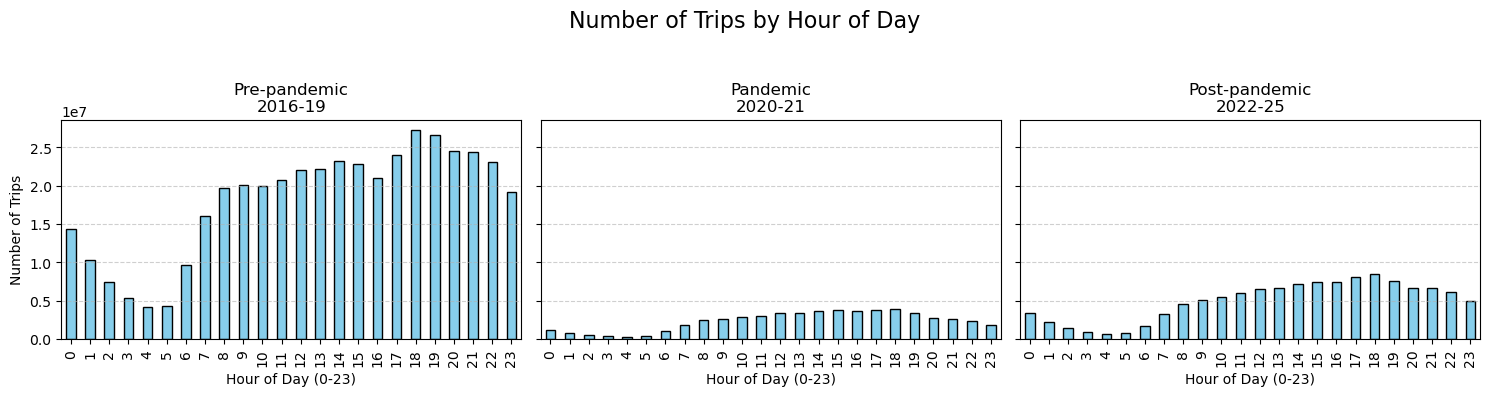

In [2]:
def trip_count_histogram(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(6,4))

    trips = (df
        .assign(pickup_hour=df.tpep_pickup_datetime.dt.hour)
        .groupby("pickup_hour")
        .size()
        .compute()
    )
    trips.sort_index().plot(
        kind="bar", ax=ax,
        color="skyblue", edgecolor="black"
    )
    ax.set_title(f"{period}")
    ax.set_xlabel("Hour of Day (0-23)")
    ax.set_ylabel("Number of Trips")
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    if own_ax:
        plt.tight_layout()
        plt.show()

compare_across_periods(
    trip_count_histogram, df_all, periods,
    figsize=(15,4),
    suptitle="Number of Trips by Hour of Day"
)


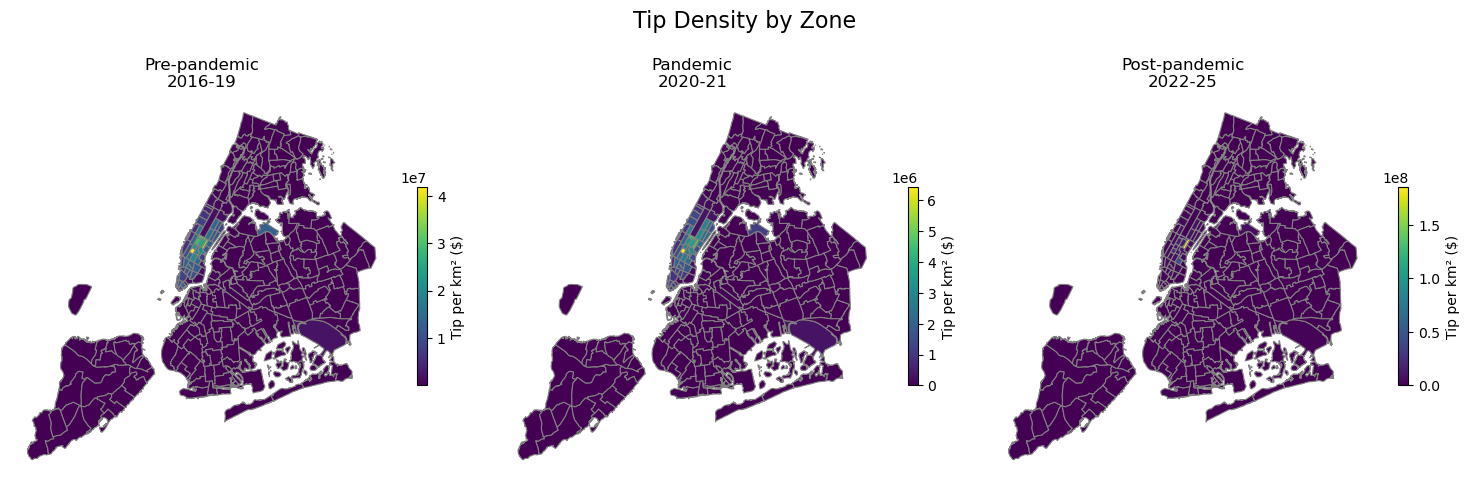

In [ ]:
def tip_map_normalized(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    df["tip_amount"] = df["tip_amount"].clip(upper=500)

    tip_sum = (
        df.groupby("pulocationid")["tip_amount"]
          .sum().compute()
          .reset_index().rename(columns={
             "pulocationid":"LocationID","tip_amount":"total_tip"
          })
    )

    taxi_zones = (gpd.read_file("DB/taxi_zones/taxi_zones.shp")
                      .to_crs(epsg=3857))
    taxi_zones["area_km2"] = taxi_zones.geometry.area / 1e6

    zones = taxi_zones.merge(tip_sum, on="LocationID", how="left")
    zones["total_tip"] = zones["total_tip"].fillna(0)
    zones["tip_per_km2"] = zones["total_tip"] / zones["area_km2"]
    zones = zones.to_crs(epsg=4326)

    zones.plot(
        column="tip_per_km2", cmap="viridis",
        linewidth=0.8, edgecolor="gray",
        legend=True, ax=ax,
        legend_kwds={"label":"Tip per km² ($)", "shrink":0.5}
    )
    ax.set_title(period)
    ax.axis("off")

    if own_ax:
        plt.tight_layout()
        plt.show()

compare_across_periods(
    tip_map_normalized, df_all, periods,
    figsize=(15,5),
    suptitle="Tip Density by Zone"
)

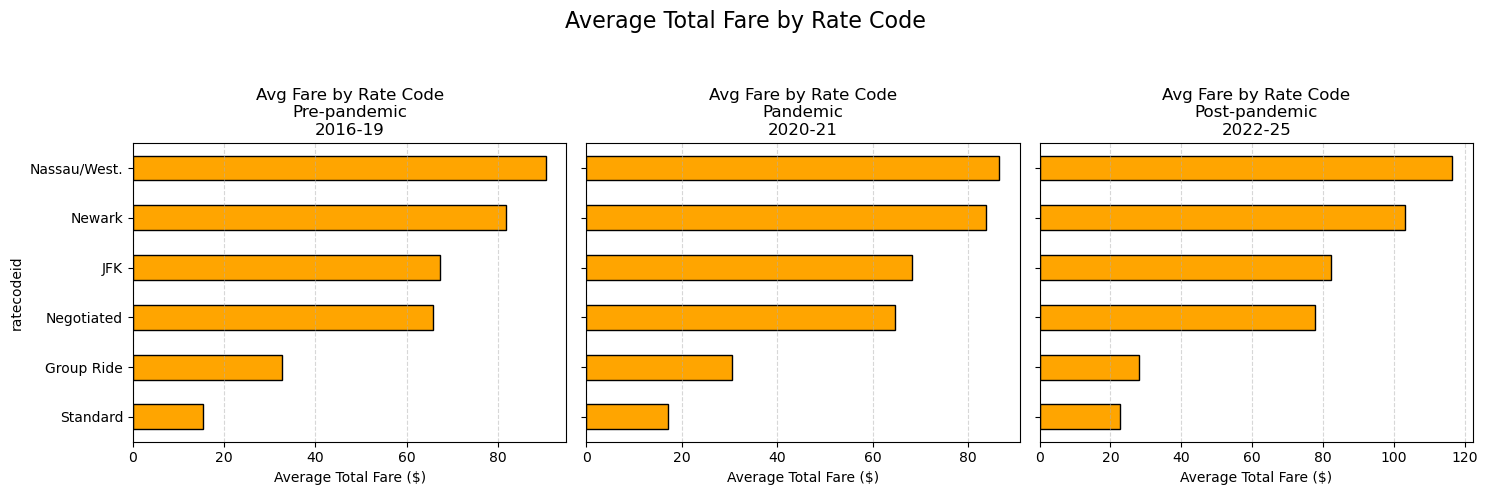

In [21]:
def rate_code_id_bar(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(8, 5))

    # ensure we’re using the right df
    pdf = df.copy()
    pdf = pdf[pdf["ratecodeid"].isin([1,2,3,4,5,6])]
    avg_fare = pdf.groupby("ratecodeid")["total_amount"].mean().compute()

    labels = {
        1: "Standard", 2: "JFK", 3: "Newark",
        4: "Nassau/West.", 5: "Negotiated", 6: "Group Ride"
    }
    avg_fare.index = avg_fare.index.map(labels)

    avg_fare.sort_values().plot(
        kind="barh", ax=ax,
        color="orange", edgecolor="black"
    )
    ax.set_xlabel("Average Total Fare ($)")
    ax.set_title(f"Avg Fare by Rate Code\n{period}")
    ax.grid(axis="x", linestyle="--", alpha=0.5)

    if own_ax:
        plt.tight_layout()
        plt.show()
        
compare_across_periods(
    rate_code_id_bar, df_all, periods,
    figsize=(15,5),
    suptitle="Average Total Fare by Rate Code"
)

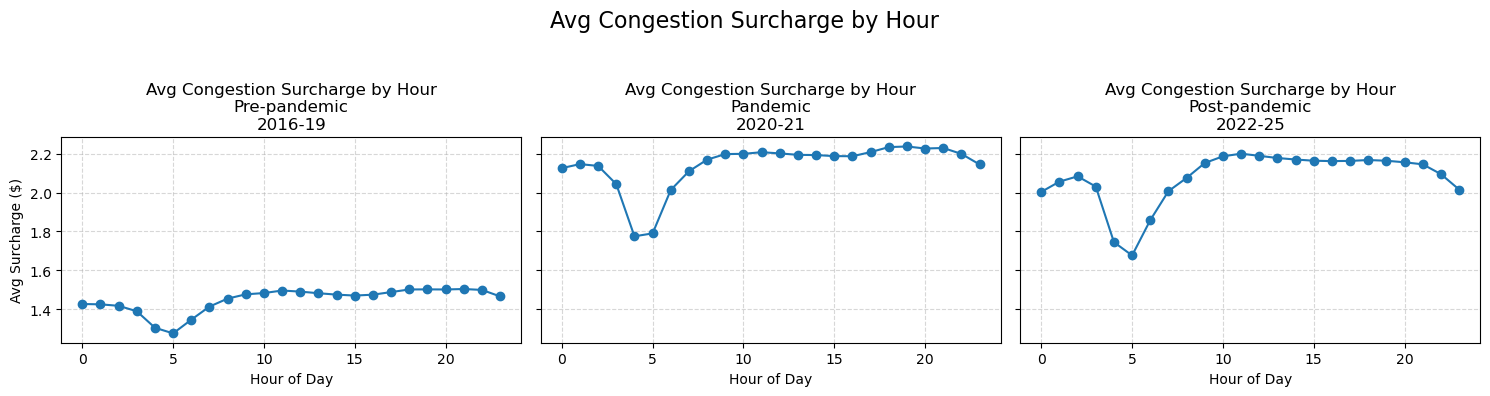

In [5]:

def congestion_plot(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(10, 5))

    pdf = df.copy()
    pdf["pickup_hour"] = pdf["tpep_pickup_datetime"].dt.hour
    surcharge_by_hour = (
        pdf.groupby("pickup_hour")["congestion_surcharge"]
           .mean().compute()
    )

    surcharge_by_hour.plot(
        ax=ax, marker="o", linestyle="-"
    )
    ax.set_title(f"Avg Congestion Surcharge by Hour\n{period}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Avg Surcharge ($)")
    ax.grid(True, linestyle="--", alpha=0.5)

    if own_ax:
        plt.tight_layout()
        plt.show()
        
compare_across_periods(
    congestion_plot, df_all, periods,
    figsize=(15,4),
    suptitle="Avg Congestion Surcharge by Hour"
)

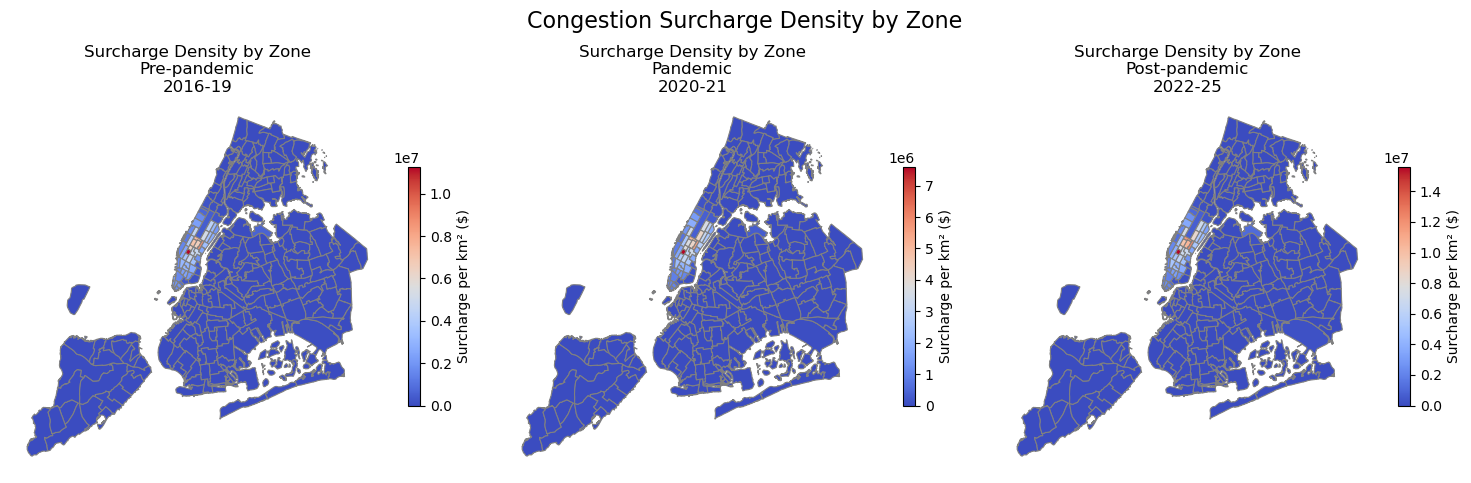

In [6]:
def congestion_map_normalized(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(12, 10))

    # 1) sum per zone
    surcharge_sum = (
        df.groupby("pulocationid")["congestion_surcharge"]
          .sum().compute()
          .reset_index()
          .rename(columns={
              "pulocationid": "LocationID",
              "congestion_surcharge": "total_surcharge"
          })
    )
    # 2) zones + area
    tz = gpd.read_file("DB/taxi_zones/taxi_zones.shp").to_crs(epsg=3857)
    tz["area_km2"] = tz.geometry.area / 1e6

    zones = tz.merge(surcharge_sum, on="LocationID", how="left")
    zones["total_surcharge"] = zones["total_surcharge"].fillna(0)
    zones["surcharge_per_km2"] = zones["total_surcharge"] / zones["area_km2"]
    zones = zones.to_crs(epsg=4326)

    zones.plot(
        column="surcharge_per_km2", cmap="coolwarm",
        linewidth=0.8, edgecolor="gray",
        legend=True, ax=ax,
        legend_kwds={"label": "Surcharge per km² ($)", "shrink": 0.6}
    )
    ax.set_title(f"Surcharge Density by Zone\n{period}")
    ax.axis("off")

    if own_ax:
        plt.tight_layout()
        plt.show()
        
compare_across_periods(
    congestion_map_normalized, df_all, periods,
    figsize=(15,5),
    suptitle="Congestion Surcharge Density by Zone"
)

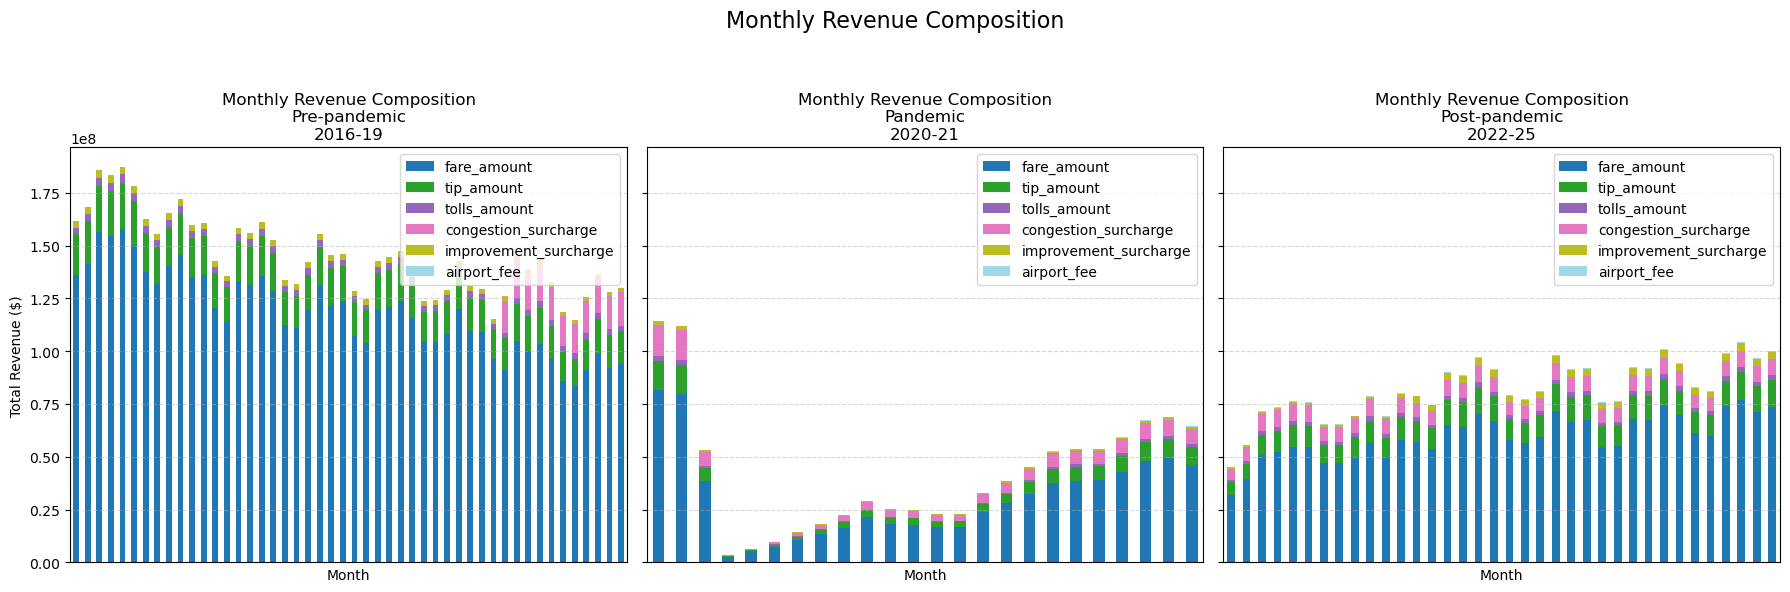

In [6]:
def revenue_comp_fare(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(14, 6))

    pdf = df.copy()
    pdf = pdf[pdf["tpep_pickup_datetime"].notnull()]
    pdf["pickup_month"] = pdf["tpep_pickup_datetime"].dt.strftime("%Y-%m")
    pdf = pdf[~pdf["pickup_month"].isnull()]

    # components forced > 0
    comps = [
        "fare_amount", "tip_amount", "tolls_amount",
        "congestion_surcharge", "improvement_surcharge", "airport_fee"
    ]
    pdf[comps] = pdf[comps].clip(lower=0)
    pdf["tip_amount"] = pdf["tip_amount"].clip(upper=500)

    monthly = (
        pdf.groupby("pickup_month")[comps]
           .sum().compute()
           .sort_index()
    )

    monthly.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        colormap="tab20"
    )
    ax.set_title(f"Monthly Revenue Composition\n{period}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Total Revenue ($)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # remove x-ticks and tick labels to declutter
    ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    if own_ax:
        plt.tight_layout()
        plt.show()

compare_across_periods(
    revenue_comp_fare, df_all, periods,
    figsize=(18,6),
    suptitle="Monthly Revenue Composition"
)

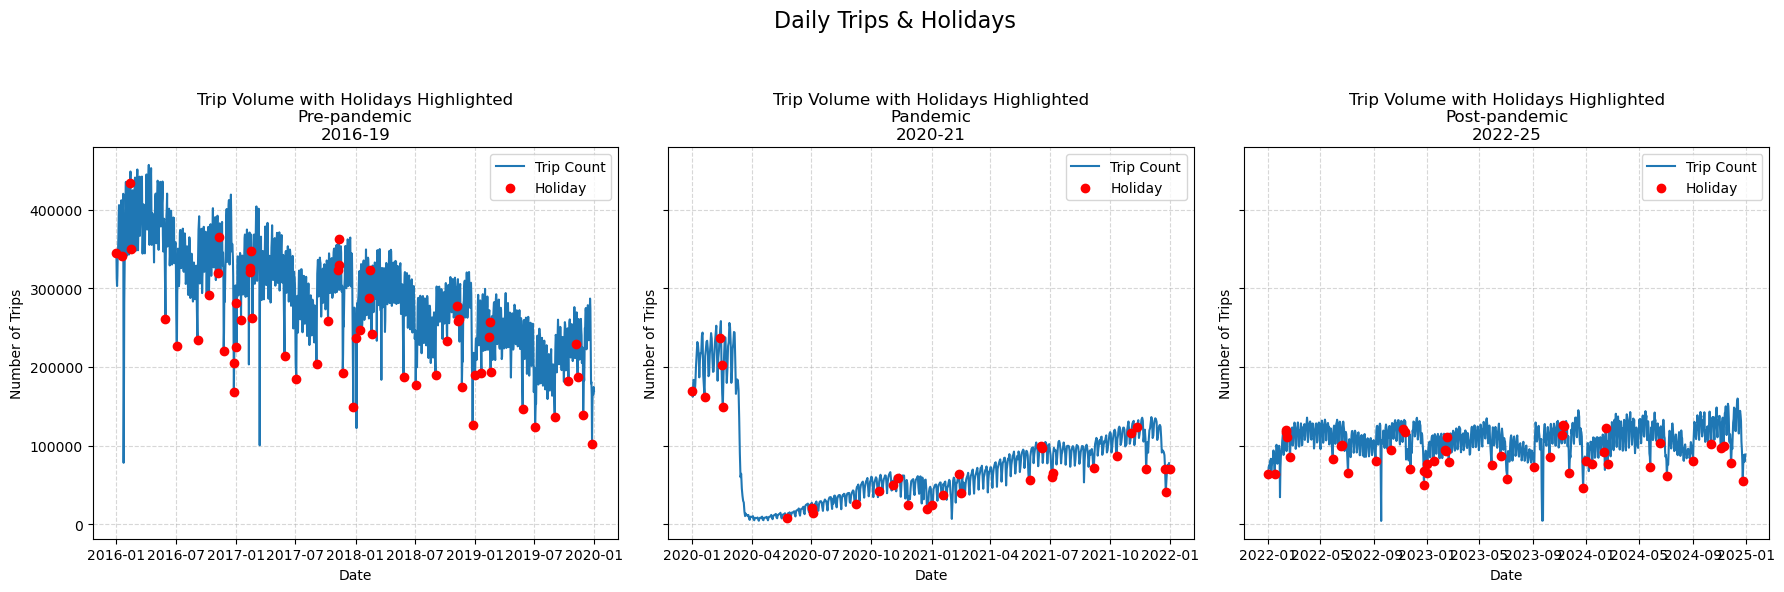

In [12]:
""" Visualizations dependant on the augmentation of holidays: """

def trips_holidays_plot(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(14, 6))

    # floor to date and compute daily counts & holiday flag
    daily = (
        df.assign(pickup_date=df.tpep_pickup_datetime.dt.floor("D"))
          .groupby("pickup_date")
          .agg({"is_holiday": "max", "tpep_pickup_datetime": "count"})
          .compute()
          .sort_index()
          .rename(columns={"tpep_pickup_datetime": "trip_count"})
    )

    # line of daily trips
    ax.plot(daily.index, daily["trip_count"], label="Trip Count", linestyle="-")

    # mark holiday days
    hols = daily.loc[daily["is_holiday"]]
    ax.scatter(hols.index, hols["trip_count"], color="red", label="Holiday", zorder=5)

    ax.set_title(f"Trip Volume with Holidays Highlighted\n{period}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Trips")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

    if own_ax:
        plt.tight_layout()
        plt.show()
        
compare_across_periods(
    trips_holidays_plot,
    df_all,
    periods,
    figsize=(18,6),
    suptitle="Daily Trips & Holidays"
)

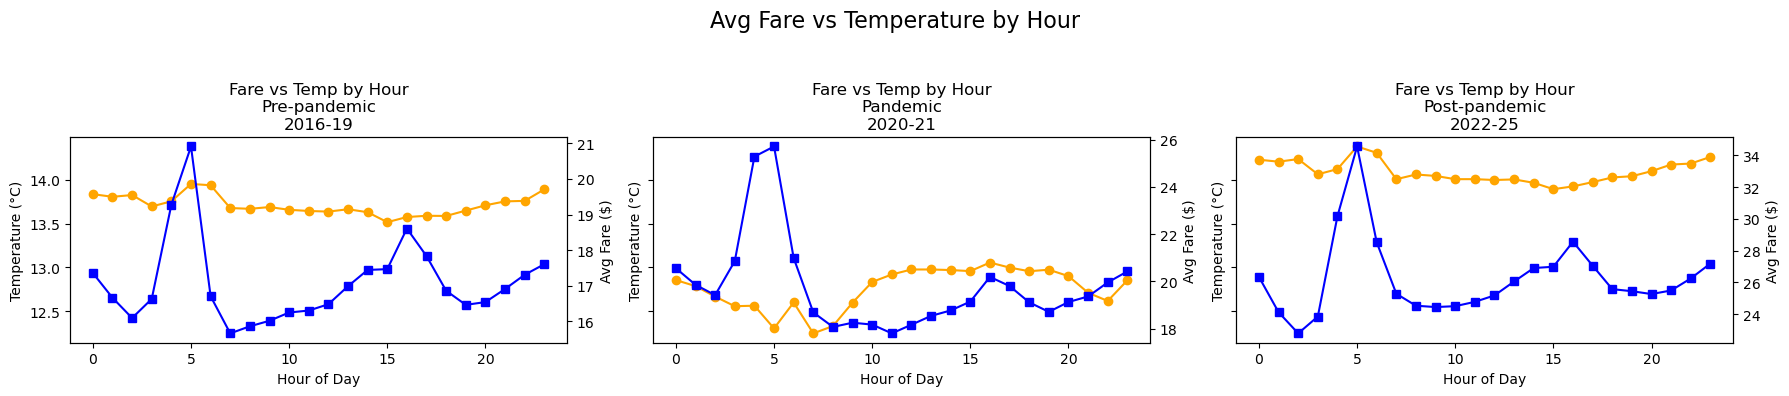

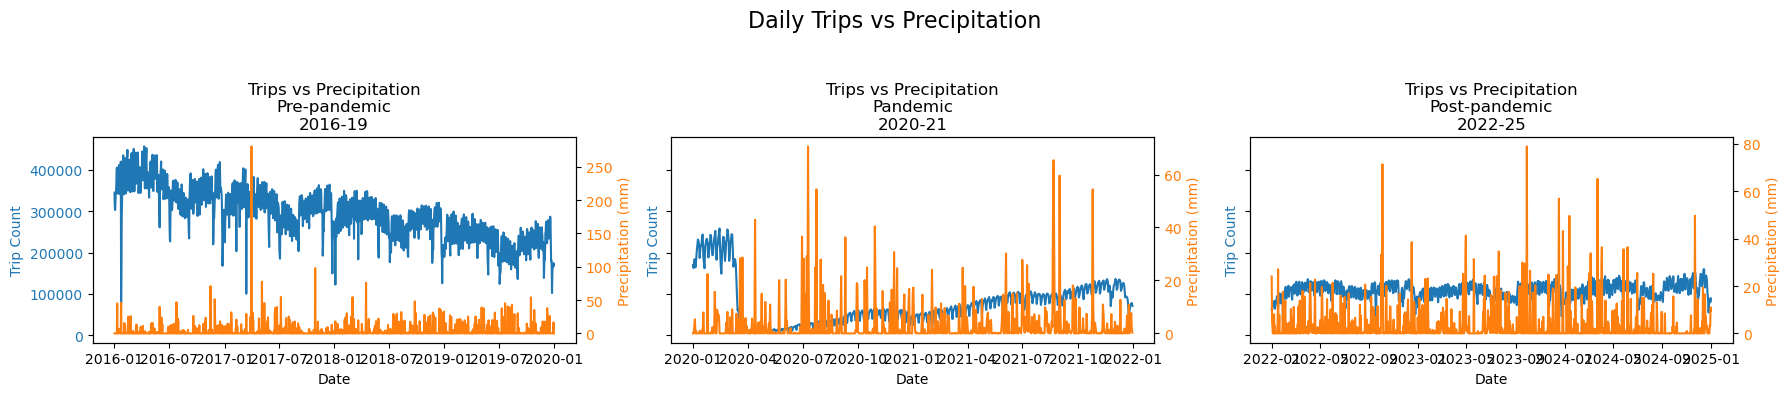

In [13]:
""" Visualizations dependant on the augmentation of weather: """

def fare_temperature_plot(df, period, ax=None):
    """
    Dual-axis plot of avg. temperature vs avg. fare by hour.
    If ax is None, creates its own figure+axes and calls plt.show().
    """
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(6,4))

    # prepare data
    pdf = df.copy()
    pdf["pickup_hour"] = pdf["tpep_pickup_datetime"].dt.hour
    hourly = (
        pdf.groupby("pickup_hour")[["avg_temp_c","total_amount"]]
           .mean().compute()
           .sort_index()
    )

    # primary axis: temperature
    ax.plot(hourly.index, hourly["avg_temp_c"],
            label="Avg Temp (°C)", color="orange", marker="o")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Temperature (°C)")
    ax.set_title(f"Fare vs Temp by Hour\n{period}")

    # secondary axis: fare
    ax2 = ax.twinx()
    ax2.plot(hourly.index, hourly["total_amount"],
             label="Avg Fare ($)", color="blue", marker="s")
    ax2.set_ylabel("Avg Fare ($)")

    # shared legend
    if own_ax:
        # combine legends from both axes
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        fig.legend(lines+lines2, labels+labels2, loc="upper center")
        plt.tight_layout()
        plt.show()


def trips_rain_plot(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(6,4))

    # prepare data
    pdf = df.assign(
        pickup_date=df.tpep_pickup_datetime.dt.floor("D")
    )
    daily = (
        pdf.groupby("pickup_date")
           .agg({"precip_mm":"mean",
                 "tpep_pickup_datetime":"count"})
           .compute()
           .sort_index()
           .rename(columns={"tpep_pickup_datetime":"trip_count"})
    )

    # primary axis: trip count
    ax.plot(daily.index, daily["trip_count"],
            label="Trip Count", color="tab:blue")
    ax.set_xlabel("Date")
    ax.set_ylabel("Trip Count", color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")
    ax.set_title(f"Trips vs Precipitation\n{period}")

    # secondary axis: precipitation
    ax2 = ax.twinx()
    ax2.plot(daily.index, daily["precip_mm"],
             label="Precipitation (mm)", color="tab:orange")
    ax2.set_ylabel("Precipitation (mm)", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    if own_ax:
        # combined legend
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        fig.legend(lines+lines2, labels+labels2, loc="upper center")
        plt.tight_layout()
        plt.show()

compare_across_periods(
    fare_temperature_plot,
    df_all,
    periods,
    figsize=(18,4),
    suptitle="Avg Fare vs Temperature by Hour"
)

compare_across_periods(
    trips_rain_plot,
    df_all,
    periods,
    figsize=(18,4),
    suptitle="Daily Trips vs Precipitation"
)

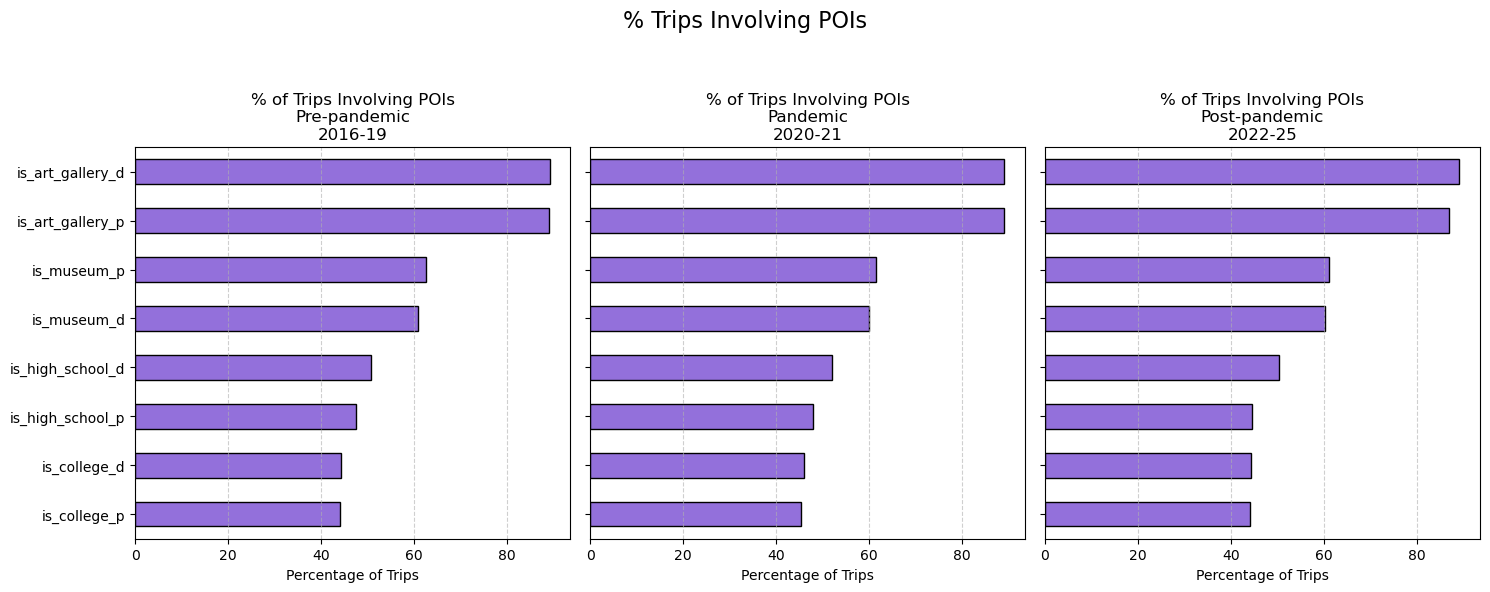

In [14]:
""" Visualizations dependant on the augmentation of POIs: """

def barh_POI(df, period, ax=None):
    own_ax = ax is None
    if own_ax:
        fig, ax = plt.subplots(figsize=(10, 6))

    pdf = df.copy()

    # find all your POI columns (no holiday flags)
    poi_cols = [
        col for col in pdf.columns 
        if col.startswith("is_") and pdf[col].dtype == "bool" and "holiday" not in col
    ]

    # mean of booleans gives fraction True, *100 → %
    poi_pct = pdf[poi_cols].mean().compute() * 100
    poi_pct = poi_pct.sort_values()

    poi_pct.plot(
        kind="barh",
        ax=ax,
        color="mediumpurple",
        edgecolor="black"
    )
    ax.set_title(f"% of Trips Involving POIs\n{period}")
    ax.set_xlabel("Percentage of Trips")
    ax.grid(axis="x", linestyle="--", alpha=0.6)

    if own_ax:
        plt.tight_layout()
        plt.show()

compare_across_periods(
    barh_POI,
    df_all,
    periods,
    figsize=(15, 6),
    suptitle="% Trips Involving POIs"
)


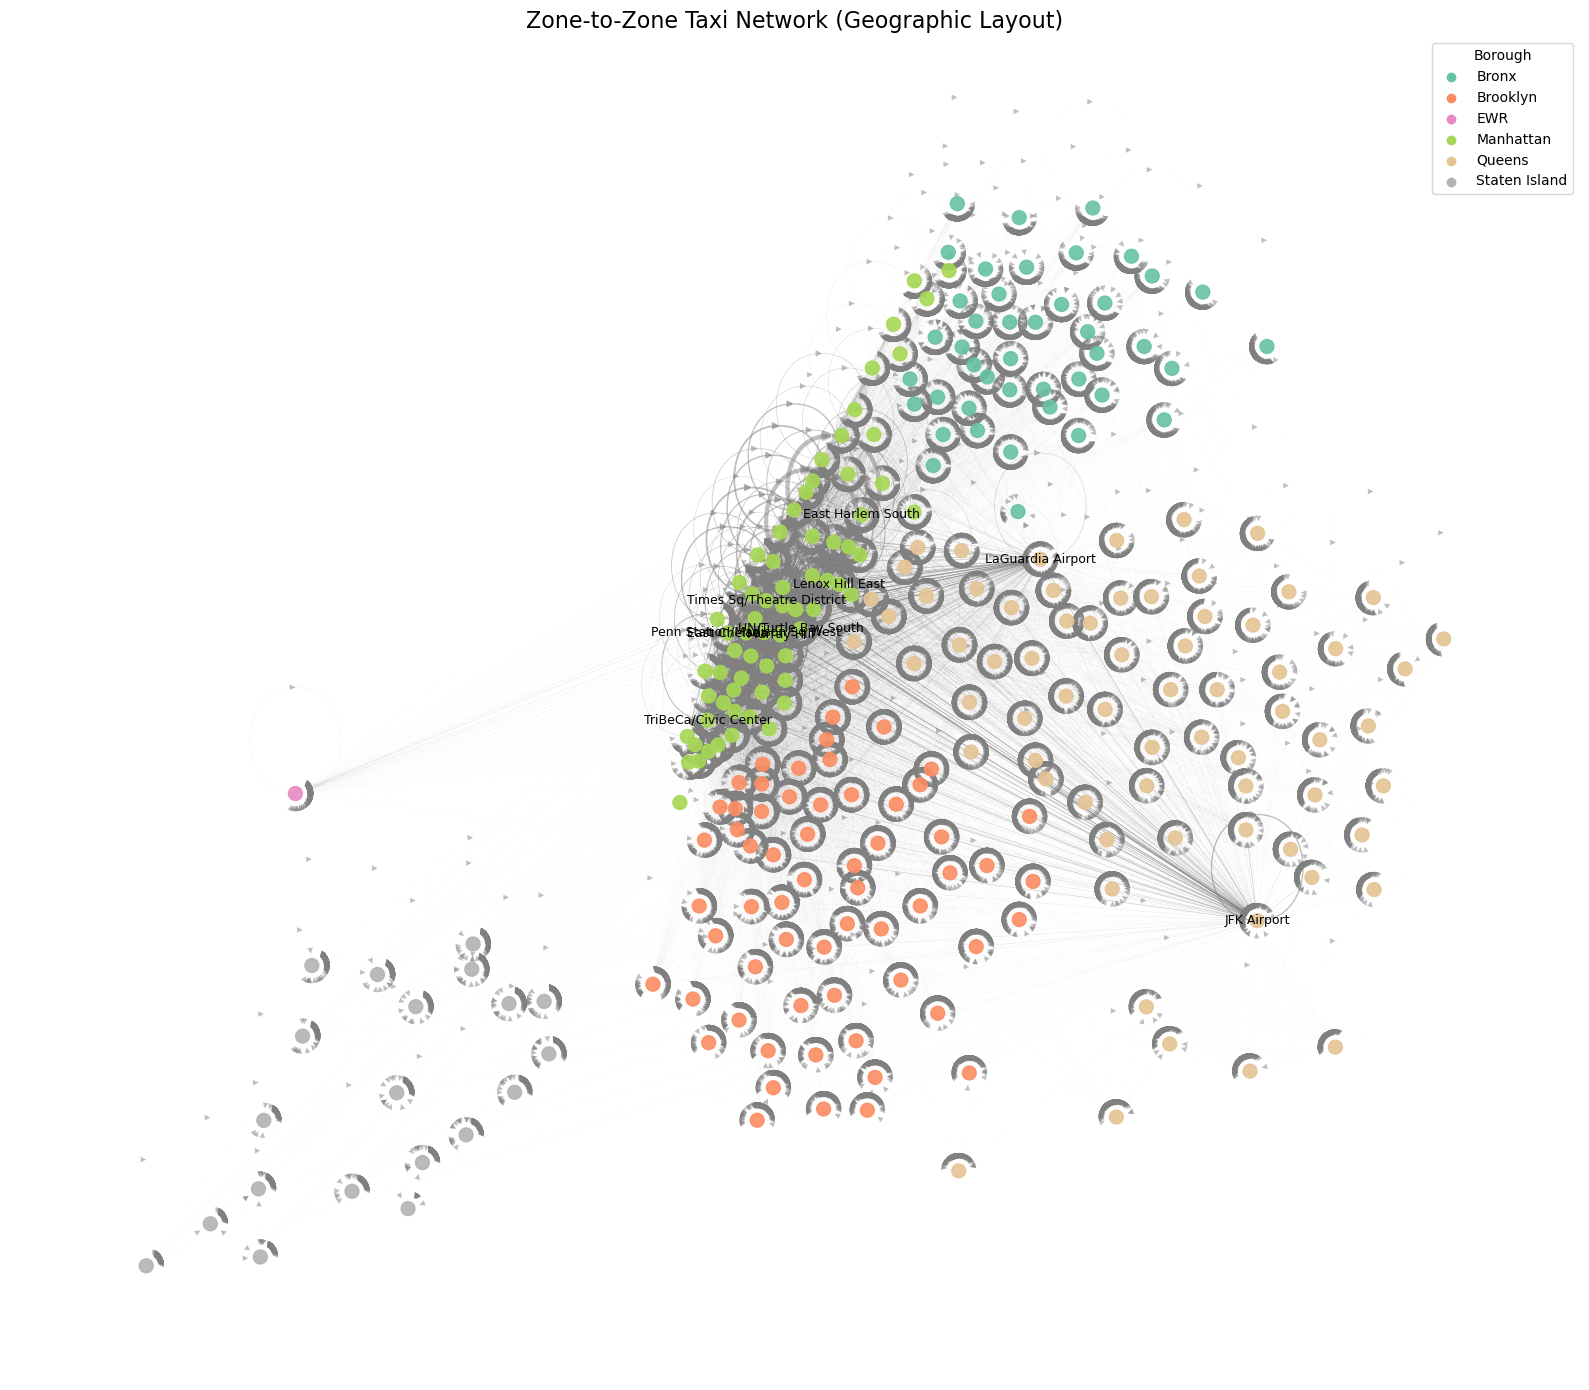

In [17]:
od_pairs = df_all.groupby(["pulocationid", "dolocationid"]).size().compute().reset_index(name="trip_count")

G = nx.DiGraph()
for _, row in od_pairs.iterrows():
    G.add_edge(int(row["pulocationid"]), int(row["dolocationid"]), weight=row["trip_count"])

# -----------------------------
# 3. Add metadata to nodes
# -----------------------------
zones = gpd.read_file("DB/taxi_zones/taxi_zones.shp")[["LocationID", "zone", "borough", "geometry"]]
zone_name_map = dict(zip(zones["LocationID"], zones["zone"]))
borough_map = dict(zip(zones["LocationID"], zones["borough"]))
geometry_map = dict(zip(zones["LocationID"], zones["geometry"].centroid))

nx.set_node_attributes(G, zone_name_map, "zone")
nx.set_node_attributes(G, borough_map, "borough")

# -----------------------------
# 4. Geo-layout (use real coordinates)
# -----------------------------
pos = {loc: (geom.x, geom.y) for loc, geom in geometry_map.items() if loc in G.nodes}

# -----------------------------
# 5. Reduce to LCC
# -----------------------------
largest_cc = max(nx.weakly_connected_components(G), key=len)
# Restrict to nodes that have coordinates
G_lcc = G.subgraph(largest_cc).copy()
valid_nodes = set(pos.keys())
G_lcc = G_lcc.subgraph(valid_nodes).copy()
# -----------------------------
# 6. Node colors by borough
# -----------------------------
boroughs = sorted(set(borough_map.values()))
cmap = plt.get_cmap("Set2", len(boroughs))
borough_color_map = {b: mcolors.rgb2hex(cmap(i)) for i, b in enumerate(boroughs)}

node_colors = [
    borough_color_map.get(G_lcc.nodes[n].get("borough", "Unknown"), "#cccccc")
    for n in G_lcc.nodes
]

# -----------------------------
# 7. Edge weights for visual thickness
# -----------------------------
weights = [G_lcc[u][v]["weight"] for u, v in G_lcc.edges()]
max_weight = max(weights)
scaled_weights = [w / max_weight * 4 for w in weights]

# -----------------------------
# 8. Draw the graph
# -----------------------------
plt.figure(figsize=(16, 14))
nx.draw_networkx_nodes(G_lcc, pos, node_color=node_colors, node_size=100, alpha=0.9)
nx.draw_networkx_edges(G_lcc, pos, width=scaled_weights, edge_color="gray", alpha=0.5)

# Label top zones only
top_nodes = sorted(G_lcc.degree, key=lambda x: x[1], reverse=True)[:10]
labels = {n: G_lcc.nodes[n]["zone"] for n, _ in top_nodes}
nx.draw_networkx_labels(G_lcc, pos, labels=labels, font_size=9)

# Borough legend
for b, c in borough_color_map.items():
    plt.scatter([], [], c=c, label=b)
plt.legend(scatterpoints=1, frameon=True, title="Borough")

plt.title("Zone-to-Zone Taxi Network (Geographic Layout)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

In [18]:
# -----------------------------
# Filter to Manhattan-only nodes
# -----------------------------
manhattan_nodes = [n for n in G_lcc.nodes if G_lcc.nodes[n].get("borough") == "Manhattan"]

# Induce subgraph of Manhattan
G_manhattan = G_lcc.subgraph(manhattan_nodes).copy()

# Also filter position and color maps
pos_manhattan = {n: pos[n] for n in G_manhattan.nodes}
node_colors_manhattan = [
    borough_color_map.get("Manhattan", "#cccccc") for _ in G_manhattan.nodes
]

# Edge weights
weights_manhattan = [G_manhattan[u][v]["weight"] for u, v in G_manhattan.edges()]
max_w = max(weights_manhattan) if weights_manhattan else 1
scaled_weights_manhattan = [w / max_w * 4 for w in weights_manhattan]


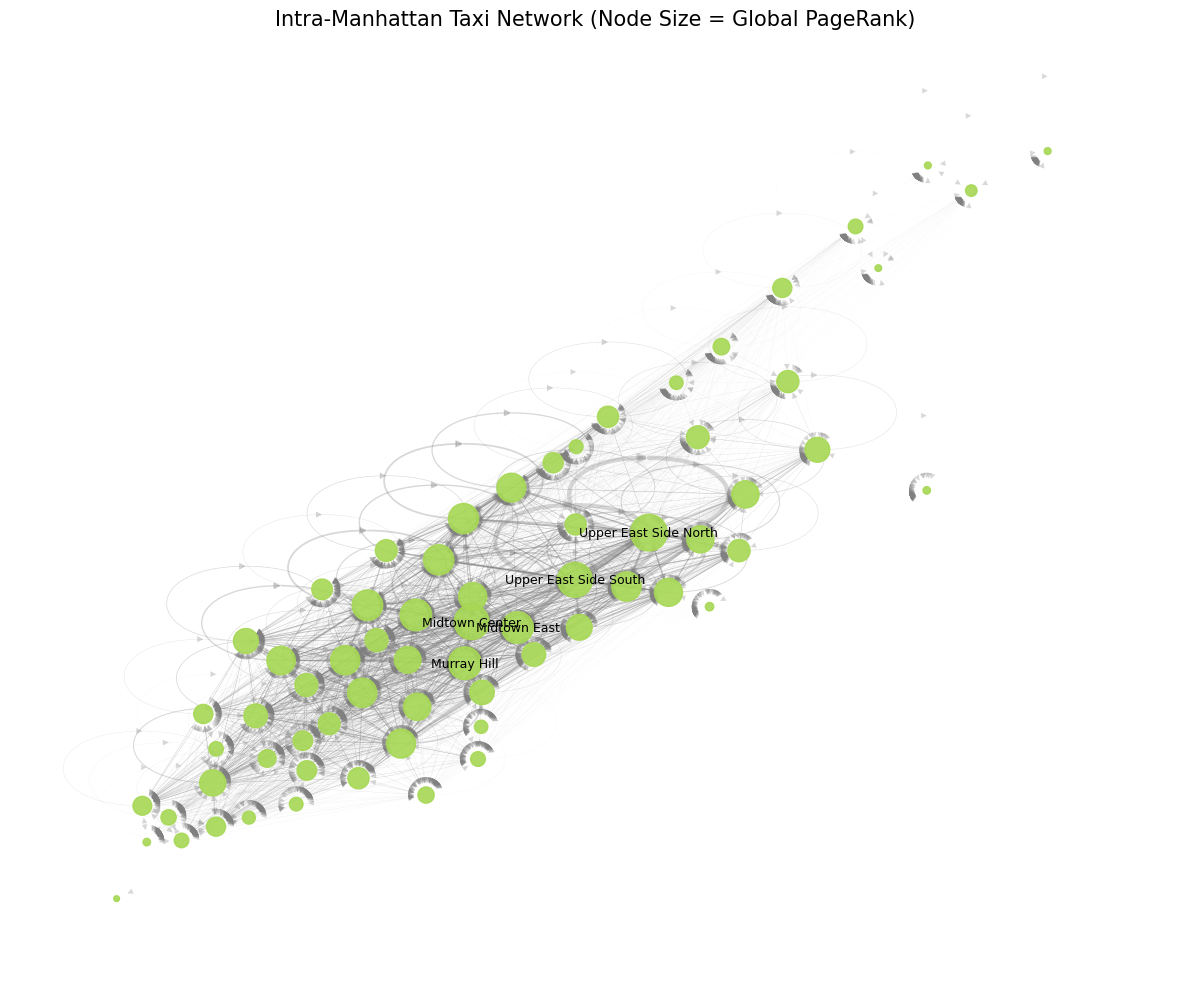

In [19]:
# Compute PageRank for Manhattan subgraph
pagerank_global = nx.pagerank(G_lcc, weight="weight")
# Nodes in Manhattan
manhattan_nodes = [n for n in G_lcc.nodes if G_lcc.nodes[n].get("borough") == "Manhattan"]

# Induce Manhattan subgraph
G_manhattan = G_lcc.subgraph(manhattan_nodes).copy()

# Geometry + style
pos_manhattan = {n: pos[n] for n in G_manhattan.nodes}
node_colors_manhattan = [borough_color_map["Manhattan"]] * len(G_manhattan.nodes)

# Edge weights
weights_manhattan = [G_manhattan[u][v]["weight"] for u, v in G_manhattan.edges()]
max_w = max(weights_manhattan) if weights_manhattan else 1
scaled_weights_manhattan = [w / max_w * 4 for w in weights_manhattan]

# PageRank values restricted to Manhattan
pagerank_manhattan = {n: pagerank_global[n] for n in G_manhattan.nodes}
sizes_pr_m = [pagerank_manhattan[n] * 30_000 for n in G_manhattan.nodes]

# Label top 5 in Manhattan
top5_pr_m = sorted(pagerank_manhattan.items(), key=lambda x: x[1], reverse=True)[:5]
labels_pr_m = {n: G_manhattan.nodes[n]["zone"] for n, _ in top5_pr_m}

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G_manhattan, pos_manhattan, node_color=node_colors_manhattan, node_size=sizes_pr_m, alpha=0.9)
nx.draw_networkx_edges(G_manhattan, pos_manhattan, width=scaled_weights_manhattan, edge_color="gray", alpha=0.3)
nx.draw_networkx_labels(G_manhattan, pos_manhattan, labels=labels_pr_m, font_size=9)

plt.title("Intra-Manhattan Taxi Network (Node Size = Global PageRank)", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()
